In [1]:
from neuralNet import MatrixNeuralNet, ConvexNeuralNet, LinearNeuralNet
from pdes import LinearQuadraticRegulator2D, NonLinear
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from icnn import get_model
from utils import setLogger

setLogger("training")

# Linear layers

In [3]:
layers = [2, 32, 32, 1]
network = LinearNeuralNet(layers)
print( network.model )
gamma = {'data': 0, 'gradient': 0, 'residual': 1}
pde = LinearQuadraticRegulator2D( network, gamma )

lrs = [1e-2, 1e-3]
iterations = [1000, 2000]

resu = pde.train(
    interiorPointCount=10,
    dataPointCount=10,
    lrs=lrs,
    iterations=iterations,
    sampling='random'
    )

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=32, out_features=1, bias=True)
)
2024-08-24 16:19:14,281 - training - INFO - 0 / 3000 (0 / 1000), lr:1.0e-02, loss:1.14e-01 (data: 0.00e+00, grad: 0.00e+00, res: 1.14e-01)
2024-08-24 16:19:30,754 - training - INFO - 1000 / 3000 (0 / 2000), lr:1.0e-03, loss:1.10e-06 (data: 0.00e+00, grad: 0.00e+00, res: 1.10e-06)
2024-08-24 16:19:46,999 - training - INFO - 2000 / 3000 (1000 / 2000), lr:1.0e-03, loss:3.92e-07 (data: 0.00e+00, grad: 0.00e+00, res: 3.92e-07)


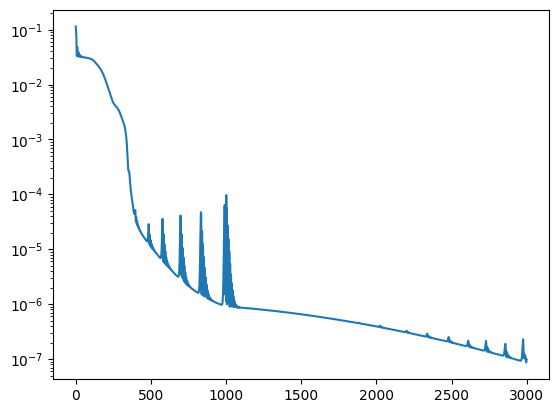

In [4]:
ax = resu['loss'].plot()
ax.set_yscale("log")

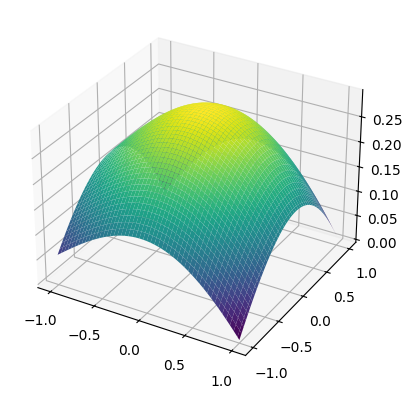

In [5]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints() 

Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

# Convex network

In [6]:
layers = [2, 32, 32, 1]
convexModel = get_model("icnn", layers=layers, bad_init=True, activation='elu')
network = ConvexNeuralNet( layers, convexModel)
gamma = {'data': 0, 'gradient': 0, 'residual': 1}
pde = LinearQuadraticRegulator2D( network, gamma )

print(network.model)

lrs = [1e-3, 1e-4, 1e-5]
iterations = [1000, 2000, 3000]

resu = pde.train(
    interiorPointCount=100,
    dataPointCount=10,
    lrs=lrs,
    iterations=iterations,
    sampling='random'
    )

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): ELU(alpha=1.0)
  (2): ConvexLinear(in_features=32, out_features=32, bias=True)
  (3): ELU(alpha=1.0)
  (4): ConvexLinear(in_features=32, out_features=1, bias=True)
)
2024-08-24 16:20:58,527 - training - INFO - 0 / 6000 (0 / 1000), lr:1.0e-03, loss:6.21e-02 (data: 0.00e+00, grad: 0.00e+00, res: 6.21e-02)


2024-08-24 16:21:15,910 - training - INFO - 1000 / 6000 (0 / 2000), lr:1.0e-04, loss:2.67e-05 (data: 0.00e+00, grad: 0.00e+00, res: 2.67e-05)
2024-08-24 16:21:35,053 - training - INFO - 2000 / 6000 (1000 / 2000), lr:1.0e-04, loss:1.29e-05 (data: 0.00e+00, grad: 0.00e+00, res: 1.29e-05)
2024-08-24 16:21:51,644 - training - INFO - 3000 / 6000 (0 / 3000), lr:1.0e-05, loss:8.98e-06 (data: 0.00e+00, grad: 0.00e+00, res: 8.98e-06)
2024-08-24 16:22:08,744 - training - INFO - 4000 / 6000 (1000 / 3000), lr:1.0e-05, loss:8.13e-06 (data: 0.00e+00, grad: 0.00e+00, res: 8.13e-06)
2024-08-24 16:22:24,297 - training - INFO - 5000 / 6000 (2000 / 3000), lr:1.0e-05, loss:7.04e-06 (data: 0.00e+00, grad: 0.00e+00, res: 7.04e-06)


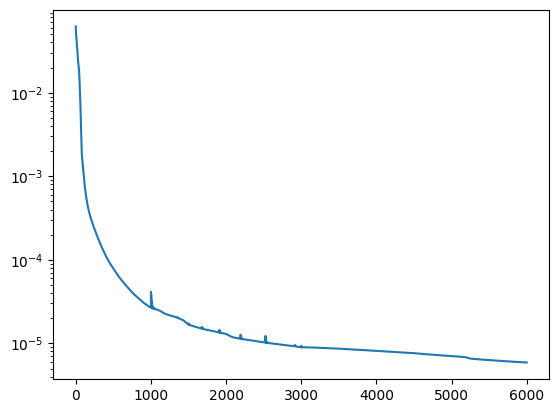

In [7]:
ax = resu['loss'].plot()
ax.set_yscale("log")

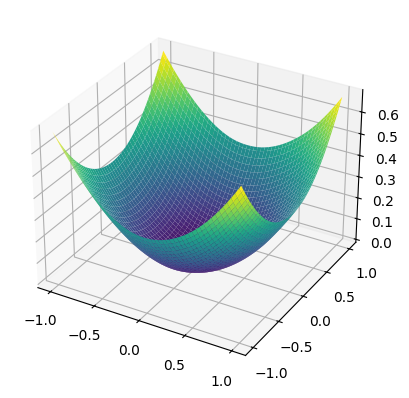

In [8]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints()

Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

## Activation function experiments

In [ ]:
from icnn import ACTIVATION_FUNCTIONS

res = []

for key in ACTIVATION_FUNCTIONS.keys():
    convexModel = get_model("icnn", num_hidden=32, bad_init=True, activation=key)
    network = ConvexNeuralNet( layers, convexModel)
    gamma = {'data': 0, 'gradient': 0, 'residual': 1}
    pde = LinearQuadraticRegulator2D( network, gamma )

    print(network.model)

    lrs = [1e-3, 1e-4, 1e-5]
    iterations = [1000, 2000, 3000]

    resu = pde.train(
        interiorPointCount=100,
        dataPointCount=10,
        lrs=lrs,
        iterations=iterations,
        sampling='random'
        )
    
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)

    X, Y = np.meshgrid(x, y)
    space = pde.getEvaluationPoints()

    Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()
    res.append({"activation": key, "loss": resu['loss'].iloc[-1], "value": Z})

In [ ]:
res = pd.DataFrame(res).sort_values("loss")

In [ ]:
res

,activation,loss,value
19,tanhshrink,4.718160e-07,"[[tensor(0.0010, grad_fn=<UnbindBackward0>), t..."
22,logsoftmax,1.099053e-06,"[[tensor(0.0005, grad_fn=<UnbindBackward0>), t..."
14,mish,1.188483e-06,"[[tensor(0.6886, grad_fn=<UnbindBackward0>), t..."
11,gelu,1.490040e-06,"[[tensor(0.6900, grad_fn=<UnbindBackward0>), t..."
0,elu,3.129890e-06,"[[tensor(0.6931, grad_fn=<UnbindBackward0>), t..."
10,celu,3.539543e-06,"[[tensor(0.6777, grad_fn=<UnbindBackward0>), t..."
4,logsigmoid,7.563614e-06,"[[tensor(0., grad_fn=<UnbindBackward0>), tenso..."
17,softsign,1.099388e-05,"[[tensor(0.0712, grad_fn=<UnbindBackward0>), t..."
18,tanh,4.391839e-05,"[[tensor(0., grad_fn=<UnbindBackward0>), tenso..."
12,sigmoid,1.233648e-04,"[[tensor(0., grad_fn=<UnbindBackward0>), tenso..."


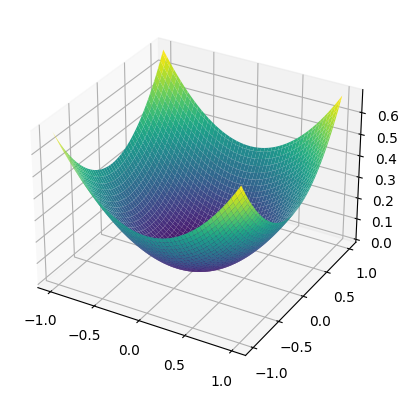

In [ ]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints()

Z = res[res['activation'] == 'gelu']['value'].item()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

In [ ]:
SELECTED_ACTIVATION = ["mish", "gelu", "celu", "elu", "selu"]

In [ ]:
res = []

for key in SELECTED_ACTIVATION * 10:
    layers = [2, 20, 20, 1]
    convexModel = get_model("icnn", num_hidden=32, bad_init=True, activation=key)
    network = ConvexNeuralNet( layers, convexModel)
    gamma = {'data': 0, 'gradient': 0, 'residual': 1}
    pde = LinearQuadraticRegulator2D( network, gamma )

    print(network.model)

    lrs = [1e-3, 1e-4, 1e-5]
    iterations = [1000, 2000, 3000]

    resu = pde.train(
        interiorPointCount=100,
        dataPointCount=10,
        lrs=lrs,
        iterations=iterations,
        sampling='random'
        )
    
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)

    X, Y = np.meshgrid(x, y)
    space = pde.getEvaluationPoints()

    Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()
    res.append({"activation": key, "loss": resu['loss'].iloc[-1], "value": Z})

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): Mish()
  (2): ConvexLinear(in_features=32, out_features=32, bias=True)
  (3): Mish()
  (4): ConvexLinear(in_features=32, out_features=1, bias=True)
)
2024-08-05 21:35:42,542 - training - INFO - 0 / 6000 (0 / 1000), lr:1.0e-03, loss:7.82e-02 (data: 0.00e+00, grad: 0.00e+00, res: 7.82e-02)
2024-08-05 21:35:42,542 - training - INFO - 0 / 6000 (0 / 1000), lr:1.0e-03, loss:7.82e-02 (data: 0.00e+00, grad: 0.00e+00, res: 7.82e-02)
2024-08-05 21:35:44,319 - training - INFO - 1000 / 6000 (0 / 2000), lr:1.0e-04, loss:3.86e-05 (data: 0.00e+00, grad: 0.00e+00, res: 3.86e-05)
2024-08-05 21:35:44,319 - training - INFO - 1000 / 6000 (0 / 2000), lr:1.0e-04, loss:3.86e-05 (data: 0.00e+00, grad: 0.00e+00, res: 3.86e-05)
2024-08-05 21:35:46,063 - training - INFO - 2000 / 6000 (1000 / 2000), lr:1.0e-04, loss:6.06e-06 (data: 0.00e+00, grad: 0.00e+00, res: 6.06e-06)
2024-08-05 21:35:46,063 - training - INFO - 2000 / 6000 (1000 / 200

In [ ]:
res = pd.DataFrame(res).sort_values("loss")

In [ ]:
res.groupby("activation")['loss'].max()

activation
celu    0.000007
elu     0.000005
gelu    0.000002
mish    0.000002
selu    0.004279
Name: loss, dtype: float64

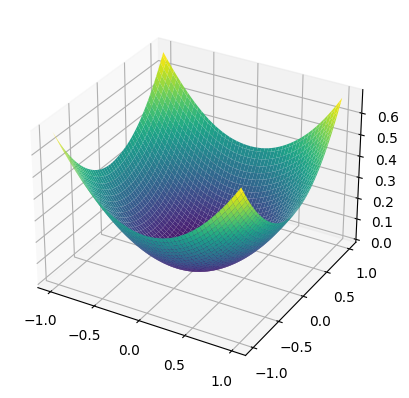

In [ ]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints()

Z = res[res['activation'] == 'celu']['value'].iloc[9]

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

In [ ]:
SELECTED_ACTIVATION_FUNCTION = ["celu", "elu", "gelu", "mish"]

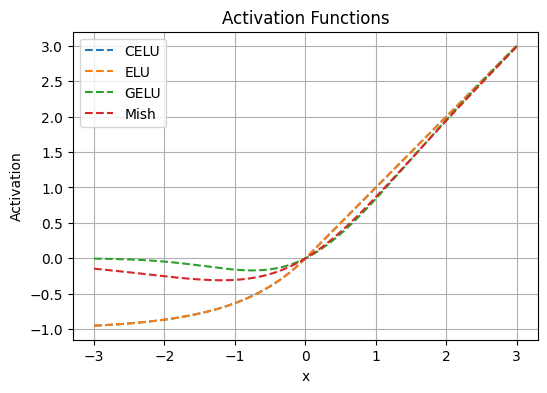

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def celu(x, alpha=1.0):
    return np.maximum(0, x) + np.minimum(0, alpha * (np.exp(x / alpha) - 1))

def elu(x, alpha=1.0):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))

def mish(x):
    return x * np.tanh(np.log1p(np.exp(x)))

x = np.linspace(-3, 3, 400)

plt.figure(figsize=(6, 4))

plt.plot(x, celu(x), label='CELU', linestyle='--')
plt.plot(x, elu(x), label='ELU', linestyle='--')
plt.plot(x, gelu(x), label='GELU', linestyle='--')
plt.plot(x, mish(x), label='Mish', linestyle='--')

plt.title('Activation Functions')
plt.xlabel('x')
plt.ylabel('Activation')
plt.legend()
plt.grid(True)

plt.show()  


# Non linear example

In [ ]:
layers = [2, 20, 20, 1]
convexModel = get_model("convex", num_hidden=32, bad_init=True, activation='gelu')
network = ConvexNeuralNet( layers, convexModel)
gamma = {'data': 0, 'gradient': 0, 'residual': 1}
pde = NonLinear( network, gamma )

print(network.model)

lrs = [1e-1, 1e-2, 1e-3, 1e-4]
iterations = [1000, 2000, 3000, 4000]

resu = pde.train(
    interiorPointCount=500,
    dataPointCount=10,
    lrs=lrs,
    iterations=iterations,
    sampling='random'
    )

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): GELU(approximate=none)
  (2): ConvexLinear(in_features=32, out_features=32, bias=True)
  (3): GELU(approximate=none)
  (4): ConvexLinear(in_features=32, out_features=1, bias=True)
)
2024-08-07 08:28:03,128 - training - INFO - 0 / 10000 (0 / 1000), lr:1.0e-01, loss:3.59e+06 (data: 0.00e+00, grad: 0.00e+00, res: 3.59e+06)
2024-08-07 08:28:03,128 - training - INFO - 0 / 10000 (0 / 1000), lr:1.0e-01, loss:3.59e+06 (data: 0.00e+00, grad: 0.00e+00, res: 3.59e+06)
2024-08-07 08:28:03,128 - training - INFO - 0 / 10000 (0 / 1000), lr:1.0e-01, loss:3.59e+06 (data: 0.00e+00, grad: 0.00e+00, res: 3.59e+06)
2024-08-07 08:28:03,128 - training - INFO - 0 / 10000 (0 / 1000), lr:1.0e-01, loss:3.59e+06 (data: 0.00e+00, grad: 0.00e+00, res: 3.59e+06)
2024-08-07 08:28:06,670 - training - INFO - 1000 / 10000 (0 / 2000), lr:1.0e-02, loss:1.93e+01 (data: 0.00e+00, grad: 0.00e+00, res: 1.93e+01)
2024-08-07 08:28:06,670 - training - IN

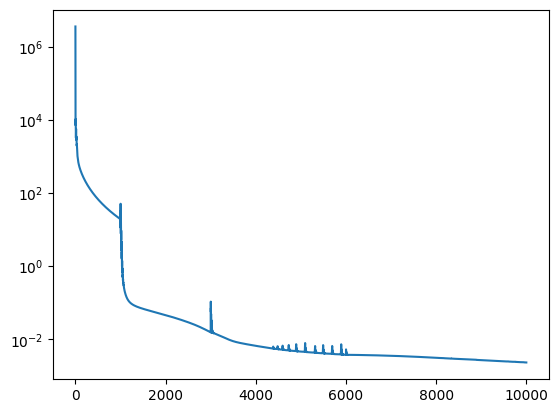

In [ ]:
ax = resu['loss'].plot()
ax.set_yscale("log")

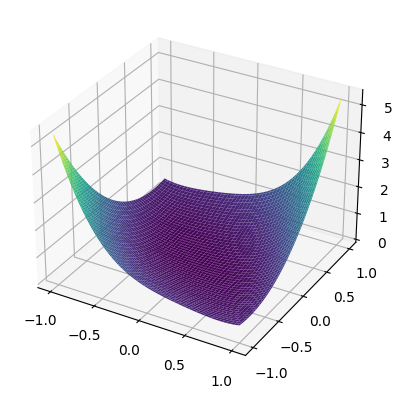

In [ ]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints() 

Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

## Activation functions experiment

In [ ]:
res = []

for key in ACTIVATION_FUNCTIONS.keys():
    for i in range(10):
        layers = [2, 20, 20, 1]
        convexModel = get_model("icnn", num_hidden=32, bad_init=True, activation=key)
        network = ConvexNeuralNet( layers, convexModel)
        gamma = {'data': 0, 'gradient': 0, 'residual': 1}
        pde = NonLinear( network, gamma )

        print(network.model)

        lrs = [1e-1, 1e-2, 1e-3, 1e-4]
        iterations = [1000, 2000, 3000, 4000]

        resu = pde.train(
            interiorPointCount=100,
            dataPointCount=10,
            lrs=lrs,
            iterations=iterations,
            sampling='random'
            )
        
        x = np.linspace(-1, 1, 100)
        y = np.linspace(-1, 1, 100)

        X, Y = np.meshgrid(x, y)
        space = pde.getEvaluationPoints()

        Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()
        res.append({"activation": key, "loss": resu['loss'].iloc[-1], "value": Z})

In [ ]:
res = pd.DataFrame(res).sort_values("loss")

In [ ]:
valueActivation = res.groupby("activation")['value'].first()
valueActivation.index

Index(['celu', 'elu', 'gelu', 'hardshrink', 'hardtanh', 'leakyrelu',
       'logsigmoid', 'logsoftmax', 'mish', 'prelu', 'relu', 'relu6', 'rrelu',
       'selu', 'sigmoid', 'silu', 'softmax', 'softmin', 'softplus',
       'softshrink', 'softsign', 'tanh', 'tanhshrink'],
      dtype='object', name='activation')

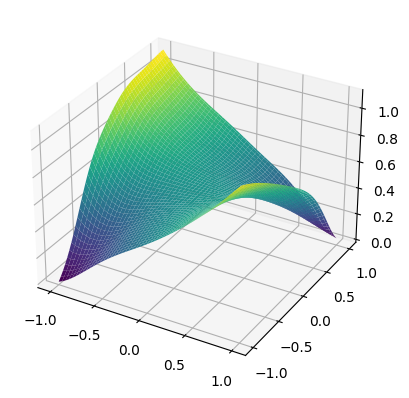

In [ ]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints() 

Z = valueActivation["tanhshrink"]

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');